In [1]:
import bagpipes as pipes
# setting bagpipes R_spec to as high as possible for perfect generation of models
pipes.config.R_spec = 4340
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)

import sys
sys.path.append('../../..')
from code_bits.fitting import *
from code_bits.add_psbtwin import *
from code_bits.add_ceh_funcs import *

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.


In [2]:
# load in true SFH
model_ages, model_sfh = load_model_sfh('../../../Yirui_test_cube/snap119/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_snap119_SFH_at_diff_radius.txt')

In [3]:
spectrum = np.loadtxt(fname='../../../Yirui_test_cube/snap119/with_PSF/no_dust/Spectrum_'+
                      "2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_no_dust_SNR15_outshining_test"+".csv", 
                      delimiter=',', skiprows=1)
obs_wavs = spectrum[:,0]

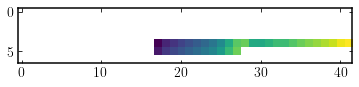

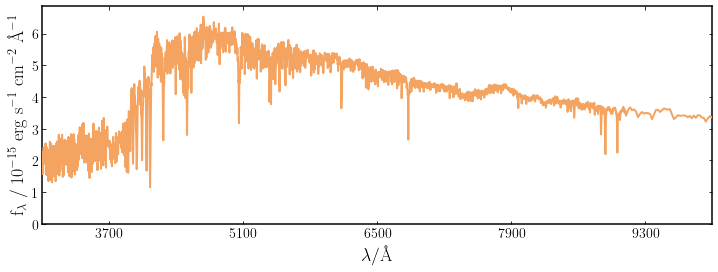

(<Figure size 864x288 with 1 Axes>,
 [<AxesSubplot:xlabel='$\\lambda / \\mathrm{\\AA}$', ylabel='$\\mathrm{f_{\\lambda}}\\ \\mathrm{/\\ 10^{-15}\\ erg\\ s^{-1}\\ cm^{-2}\\ \\AA^{-1}}$'>])

In [6]:
# create mock spectra with 1.0 zmet before burst and 2.0 after, using 2 step model
custom = {}
custom["massformed"] = 11.027233041278691
custom["history"] = np.vstack([model_ages*10**9, model_sfh]).T
custom["metallicity_type"] = "two_step"
custom["metallicity_old"] = 1.0
custom["metallicity_burst"] = 2.0
custom["metallicity_step_age"] = 0.55
custom["metallicity_scatter"] = "delta"
mc0 = {}
mc0["custom"] = custom
mc0["redshift"] = 0.04

mock_twostep = pipes.model_galaxy(mc0, spec_wavs=obs_wavs)

from matplotlib.colors import LogNorm
plt.imshow(mock_twostep.sfh.ceh.grid, norm=LogNorm())
plt.show()

mock_twostep.plot()

In [7]:
def load_manga_spec(self, ID):

    # load spectral data
    spectrum = mock_twostep.spectrum.copy()
    spectrum_noise = spectrum[:,1]/15
    spectrum = np.hstack([spectrum, np.expand_dims(spectrum_noise, axis=1)])

    # blow up the errors associated with any bad points in the spectrum and photometry
    for i in range(len(spectrum)):
        if spectrum[i,1] == 0 or spectrum[i,2] <= 0:
            spectrum[i,1] = 0.
            spectrum[i,2] = 9.9*10**99.

    # nebular emission lines and interstellar absorption lines
    mask = self.mask_em(spectrum[:,0]/(1+self.z))
    spectrum[mask, 2] = 9.9*10**99.

    # skylines
    if self.sky_masking:
        linemask = self.mask_sky(spectrum[:,0])
        spectrum[linemask, 2] = 9.9*10**99.

    for j in range(len(spectrum)):
        if (spectrum[j, 1] == 0) or (spectrum[j, 2] <= 0):
            spectrum[j, 2] = 9.9*10**99.

    # O2 telluric
    #mask = ((spectrum[:,0] > 7580.) & (spectrum[:,0] < 7650.))
    #spectrum[mask, 2] = 9.9*10**99.

    if self.full == False:
        endmask = (spectrum[:,0]/(1+self.z) < 7500) # just miles range
    else:
        endmask = (spectrum[:,0]>0)

    if self.binby > 1:
        return bin(spectrum[endmask], self.binby)
    else:
        return spectrum[endmask]
    
fitting.load_manga_spec = load_manga_spec

In [8]:
fit_obj = fitting('../../..', '../../../Yirui_test_cube/snap119_bagpipes_model/no_dust', 
                  0.04, 1, sky_masking=False, full=True)

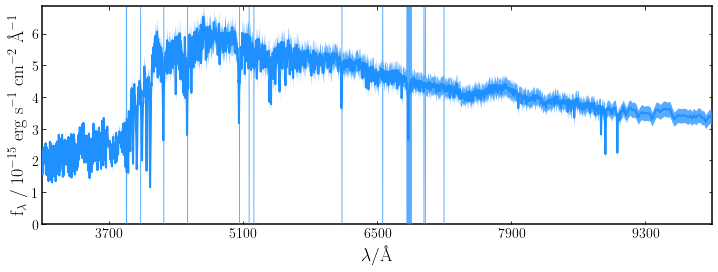

{'psb_twin': {'age': (4, 14.0), 'alpha1': (0.01, 5), 'alpha1_prior': 'log_10', 'beta1': 1000, 'massformed': (6, 13), 'metallicity_type': 'psb_two_step', 'metallicity_old': (0.01, 2.5), 'metallicity_old_prior': 'log_10', 'metallicity_burst': (0.01, 2.5), 'metallicity_burst_prior': 'log_10', 'metallicity_scatter': 'delta', 'burstage': (0, 2), 'alpha2': (0.01, 1000), 'alpha2_prior': 'log_10', 'beta2': 250.0, 'fburst': (0, 1)}, 'redshift': (0.032, 0.048)}


In [9]:
def get_fit_instructions(z=0.04):
    """ Set up the desired fit_instructions dictionary. """
    
    psb_twin = {}
    psb_twin["age"] = (4, 14.)                     # Vary age between 4 Myr and 14 Gyr. In practice 
                                          # the code automatically limits this to the age of
                                          # the Universe at the observed redshift.
    psb_twin["alpha1"] = (0.01,5)
    psb_twin["alpha1_prior"] = "log_10"
    psb_twin["beta1"] = 1000
    psb_twin["massformed"] = (6, 13)              # vary log_10(M*/M_solar) between 1 and 15
    
    psb_twin["metallicity_type"] = "psb_two_step"
    psb_twin["metallicity_old"] = (0.01, 2.5)           # vary Z between 0.1 and 2.5 Z_solar
    psb_twin["metallicity_old_prior"] = "log_10"
    psb_twin["metallicity_burst"] = (0.01, 2.5)           # vary Z between 0.1 and 2.5 Z_solar
    psb_twin["metallicity_burst_prior"] = "log_10"
    psb_twin["metallicity_scatter"] = "delta"
    
    psb_twin["burstage"] = (0,2)                   # age of burst from 0 to 2Gyr
    psb_twin["alpha2"] = (0.01,1000)               # decline of burst
    psb_twin["alpha2_prior"] = "log_10"
    psb_twin["beta2"] = 250.                    # rise of burst: fixed
    psb_twin["fburst"] = (0,1)
    
    fit_instructions = {}
    fit_instructions['psb_twin'] = psb_twin
    fit_instructions['redshift'] = (z-0.2*z, z+0.2*z)
    
    return fit_instructions

ID = 'mock_twostep_no_dust_SNR15'
z = 0.04

galaxy = pipes.galaxy(ID, fit_obj.load_manga_spec, photometry_exists=False)

fig = galaxy.plot()

fit_instructions = get_fit_instructions()
print(fit_instructions)

In [10]:
pipes.config.Rspec = 4340
runID = "twostep_recovery_no_dust_default_psbtwin_twostep_bin_by_1_4340_Rspec"
fit = pipes.fit(galaxy, fit_instructions, run=runID)

fit.fit(verbose=False)


Bagpipes: fitting object mock_twostep_no_dust_SNR15


Completed in 15599.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
psb_twin:age                   9.624     11.270     12.336
psb_twin:alpha1                0.376      0.884      1.816
psb_twin:alpha2              179.235    205.057    266.899
psb_twin:burstage              0.423      0.484      0.532
psb_twin:fburst                0.067      0.081      0.094
psb_twin:massformed           10.946     10.976     11.002
psb_twin:metallicity_burst      1.744      2.022      2.280
psb_twin:metallicity_old       1.106      1.261      1.442
redshift                       0.040      0.040      0.040




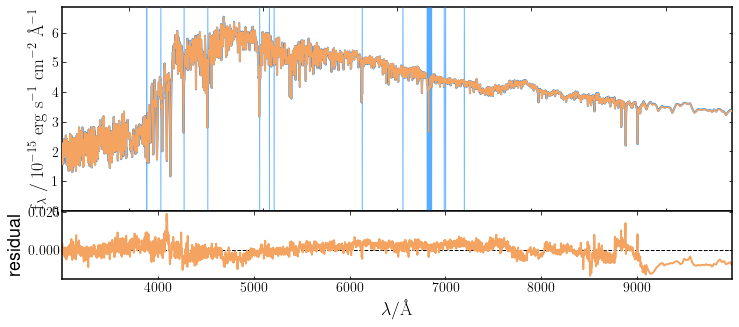

only recovered 0.8939872151292864 of total mass formed.
10.977733488157092 11.0264021801425
model f_burst and t_burst: 0.08642406323648828 12.370560314525335
posterior f_burst and t_burst: [0.06727082 0.08032563 0.09365856] [12.39679952 12.44222664 12.49847995]


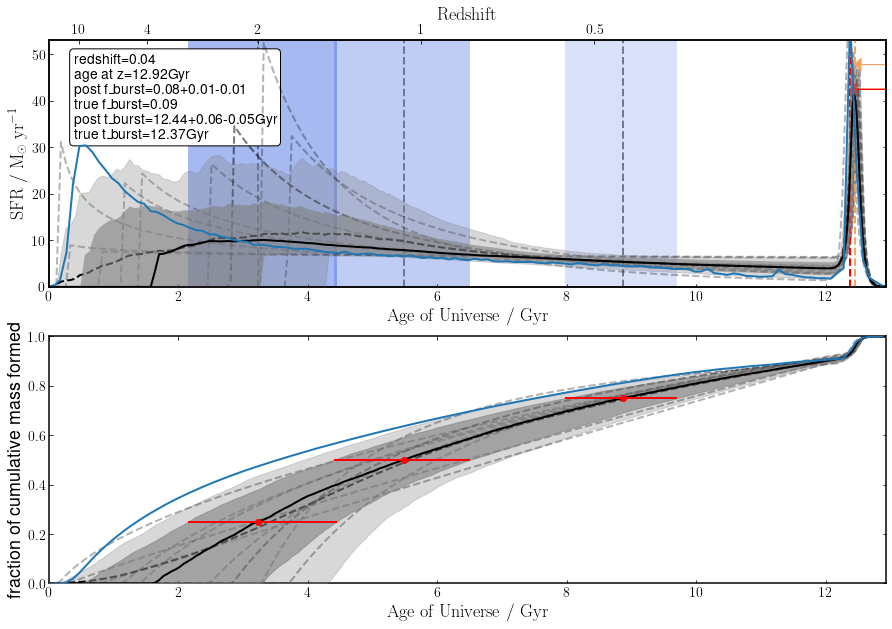

(<Figure size 1080x720 with 3 Axes>,
 array([<AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='$\\mathrm{SFR\\ /\\ M_\\odot\\ \\mathrm{yr}^{-1}}$'>,
        <AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='fraction of cumulative mass formed'>],
       dtype=object))

In [11]:
plot_spec(fit, ID, runID)
fig = fit.plot_corner(save=True, show=True)
plot_sfh(fit, model_ages, model_sfh, ID, runID, samples=10, plot_mean=True, ninty_region=True)